# MALLORN TDE Classification v1.3 - Ensemble Prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

DATA_DIR = Path('../mallorn-astronomical-classification-challenge')
sns.set_style('whitegrid')

## Tải Models

In [2]:
lgb_model = joblib.load('lgb_model.joblib')
xgb_model = joblib.load('xgb_model.joblib')
cat_model = joblib.load('cat_model.joblib')
stack_model = joblib.load('stack_model.joblib')
scaler = joblib.load('scaler.joblib')
model_info = joblib.load('model_info.joblib')

best_threshold = model_info['best_threshold']
best_method = model_info['best_method']
feature_cols = model_info['feature_cols']
weights = model_info['ensemble_weights']

print(f"v1.3 Ensemble loaded")
print(f"Best method: {best_method}")
print(f"CV F1: {model_info['best_f1']:.4f}")
print(f"Threshold: {best_threshold:.3f}")
print(f"Weights: lgb={weights['lgb']:.3f}, xgb={weights['xgb']:.3f}, cat={weights['cat']:.3f}")

v1.3 Ensemble loaded
Best method: CatBoost
CV F1: 0.6019
Threshold: 0.420
Weights: lgb=0.317, xgb=0.335, cat=0.347


## Tải Dữ liệu Test

In [3]:
test_features = pd.read_csv('test_features.csv')
test_log = pd.read_csv(DATA_DIR / 'test_log.csv')

print(f"Test features: {len(test_features)}")
print(f"Expected: {len(test_log)}")

Test features: 7135
Expected: 7135


## Tạo Dự đoán Ensemble

In [4]:
# Prepare features
for f in feature_cols:
    if f not in test_features.columns:
        test_features[f] = 0

X_test = test_features[feature_cols].values
X_test_scaled = scaler.transform(X_test)

# Get predictions from each model
lgb_proba = lgb_model.predict_proba(X_test_scaled)[:, 1]
xgb_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]
cat_proba = cat_model.predict_proba(X_test_scaled)[:, 1]

print(f"Individual predictions generated")
print(f"  LightGBM mean prob: {lgb_proba.mean():.4f}")
print(f"  XGBoost mean prob: {xgb_proba.mean():.4f}")
print(f"  CatBoost mean prob: {cat_proba.mean():.4f}")

Individual predictions generated
  LightGBM mean prob: 0.0405
  XGBoost mean prob: 0.0508
  CatBoost mean prob: 0.0699


In [5]:
# Ensemble predictions based on best method
if best_method == 'Average':
    test_proba = (lgb_proba + xgb_proba + cat_proba) / 3
elif best_method == 'Weighted':
    test_proba = weights['lgb'] * lgb_proba + weights['xgb'] * xgb_proba + weights['cat'] * cat_proba
elif best_method == 'Stacking':
    stack_features = np.column_stack([lgb_proba, xgb_proba, cat_proba])
    test_proba = stack_model.predict_proba(stack_features)[:, 1]
elif best_method == 'LightGBM':
    test_proba = lgb_proba
elif best_method == 'XGBoost':
    test_proba = xgb_proba
elif best_method == 'CatBoost':
    test_proba = cat_proba
else:
    # Default to weighted average
    test_proba = weights['lgb'] * lgb_proba + weights['xgb'] * xgb_proba + weights['cat'] * cat_proba

test_preds = (test_proba >= best_threshold).astype(int)

print(f"\nEnsemble ({best_method}) predictions:")
print(f"  TDEs: {np.sum(test_preds)} ({100*np.mean(test_preds):.2f}%)")
print(f"  Non-TDEs: {np.sum(test_preds == 0)}")


Ensemble (CatBoost) predictions:
  TDEs: 412 (5.77%)
  Non-TDEs: 6723


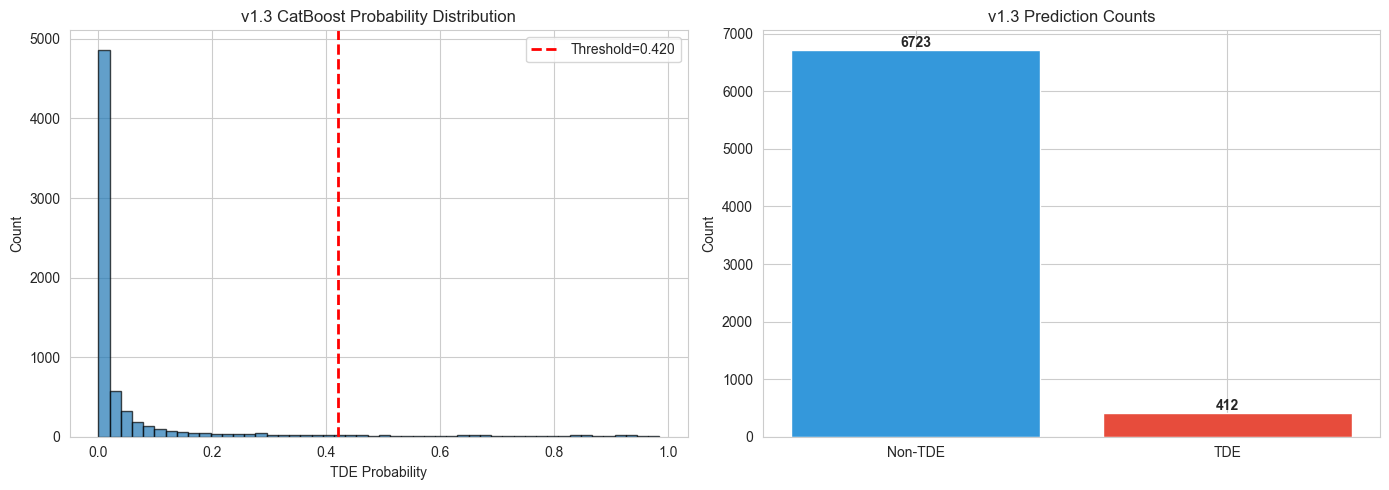

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]
ax1.hist(test_proba, bins=50, edgecolor='black', alpha=0.7)
ax1.axvline(best_threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold={best_threshold:.3f}')
ax1.set_xlabel('TDE Probability')
ax1.set_ylabel('Count')
ax1.set_title(f'v1.3 {best_method} Probability Distribution')
ax1.legend()

ax2 = axes[1]
counts = [np.sum(test_preds == 0), np.sum(test_preds == 1)]
bars = ax2.bar(['Non-TDE', 'TDE'], counts, color=['#3498db', '#e74c3c'])
ax2.set_ylabel('Count')
ax2.set_title('v1.3 Prediction Counts')
for bar, count in zip(bars, counts):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, f'{count}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('prediction_distribution.png', dpi=150)
plt.show()

## Tạo File Submission

In [7]:
submission = pd.DataFrame({
    'object_id': test_features['object_id'],
    'target': test_preds
})

# Handle missing objects
all_test_ids = set(test_log['object_id'])
submission_ids = set(submission['object_id'])
missing_ids = all_test_ids - submission_ids

if missing_ids:
    print(f"Adding {len(missing_ids)} missing objects with target=0")
    missing_df = pd.DataFrame({'object_id': list(missing_ids), 'target': 0})
    submission = pd.concat([submission, missing_df], ignore_index=True)

# Match order
submission = submission.set_index('object_id').loc[test_log['object_id']].reset_index()

print(f"\nSubmission: {len(submission)} rows")
print(f"Expected: {len(test_log)} rows")
print(f"Match: {'✓' if len(submission) == len(test_log) else '✗'}")


Submission: 7135 rows
Expected: 7135 rows
Match: ✓


In [8]:
submission.to_csv('submission.csv', index=False)

print("\n" + "="*60)
print("v1.3 ENSEMBLE SUBMISSION CREATED")
print("="*60)
print(f"File: submission.csv")
print(f"Rows: {len(submission)}")
print(f"TDEs: {submission['target'].sum()} ({100*submission['target'].mean():.2f}%)")
print(f"\nMethod: {best_method}")
print(f"CV F1: {model_info['best_f1']:.4f}")
print("="*60)


v1.3 ENSEMBLE SUBMISSION CREATED
File: submission.csv
Rows: 7135
TDEs: 412 (5.77%)

Method: CatBoost
CV F1: 0.6019


In [9]:
# Save full predictions
full_pred = pd.DataFrame({
    'object_id': test_features['object_id'],
    'lgb_proba': lgb_proba,
    'xgb_proba': xgb_proba,
    'cat_proba': cat_proba,
    'ensemble_proba': test_proba,
    'prediction': test_preds
})
full_pred.to_csv('full_predictions.csv', index=False)
print("Full predictions saved to full_predictions.csv")

Full predictions saved to full_predictions.csv
